1. [EBS (Elastic Block Storage)](#ebs-elastic-block-storage)
2. [To check for the EBS Volume attached](#to-check-for-the-ebs-volume-attached)
3. [Add more EBS Volumes](#add-more-ebs-volumes)
4. [Attach EBS Volumes to EC2](#attach-ebs-volumes-to-ec2)
5. [To format and mount file system on an EBS volume on Linux](#to-format-and-mount-file-system-on-an-ebs-volume-on-linux)
6. [To mount an attached volume automatically after reboot (Linux)](#to-mount-an-attached-volume-automatically-after-reboot-linux)
7. [To format and mount an EBS volume on Windows](#to-format-and-mount-an-ebs-volume-on-windows)
8. [EBS Snapshot](#ebs-snapshot)
9. [EBS Snapshot Features](#ebs-snapshot-features)
10. [How to create a EBS snapshot](#how-to-create-a-ebs-snapshot)
11. [To check the snapshot created](#to-check-the-snapshot-created)
12. [To copy the snapshot created](#to-copy-the-snapshot-created)
13. [To create Volume from a snapshot](#to-create-volume-from-a-snapshot)
14. [Recycle bin in Snapshot](#recycle-bin-in-snapshot)
15. [To recover the deleted EBS snapshot](#to-recover-the-deleted-ebs-snapshot)
16. [Archive Snapshot](#archive-snapshot)
17. [EBS Vs EC2 Instance store](#ebs-vs-ec2-instance-store)
18. [EBS Volume Types](#ebs-volume-types)
19. [EBS attributes](#ebs-attributes)
20. [Multi attach EBS](#Multi-attach-EBS)

#### EBS (Elastic Block Storage):
- EBS Volume
    - Network drive
    - allows data to persist even after termination
    - added to only one instance at a time. 
        - Instances can have multiple EBS but EBS can have only one instance attached
    - bound to specific availability zone (subnet)
        - eg: instance-1 (us-east-1a) can be attached to EBS (us-east-1a) and not in other AZs
        - but a snapshot of EBS can be moved across AZs
- By default, delete on termination of EC2 instance
    - It's for root volume and not for the new volume after that.
- can be changed to keep the volume even after termination
- We can add volumes as per needs

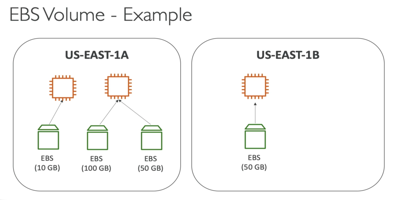

In [1]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/EBS.jpeg')
new_image = img.resize((400, 200))
display(new_image)

#### To check for the EBS Volume attached:

- Go to the instance and select the storage tab from middle of the screen
- will see Root volume and Block volume details

#### Add more EBS Volumes:
- Go to the EBS Volume option on the left side of the EC2 page
- Create Volume
    - Choose size
    - Choose AZ (should be the same as EC2 instance AZ)
    - Create Volume

Note:
- To check for AZ info for the EC2 created, go to Networking tab in the EC2 homepage

#### Attach EBS Volumes to EC2:
- In Volume section under EBS
    -  Action -> Attach Volume
        - Select the instance you want to attach the volume to
        - Attach Volume

#### To format and mount file system on an EBS volume on Linux:

https://docs.aws.amazon.com/ebs/latest/userguide/ebs-using-volumes.html

1. Connect to your instance using SSH
2. Identify the EBS volume you want to mount
3. Use "lsblk" command to view your available disk devices and their mount points
    - output of lsblk removes the /dev/ prefix from full device paths
    - eg:
        - ```[ec2-user ~]$ lsblk```
        - ```NAME    MAJ:MIN RM  SIZE RO TYPE MOUNTPOINT```
        - ```xvda    202:0    0    8G  0 disk```
        - ```-xvda1  202:1    0    8G  0 part /```
        - ```xvdf    202:80   0   10G  0 disk```
    - The root device is /dev/xvda, which has one partition named xvda1. 
    - The attached volume is /dev/xvdf, which has no partitions and is not yet mounted.
4. Determine whether there is a file system on the volume
    - New volumes are raw block devices, and you must create a file system on them before you can mount and use them
    - Volumes that were created from snapshots likely have a file system on them already
    - If you create a new file system on top of an existing file system, the operation overwrites your data.
5. Use the "file -s" command to get information about a specific device, such as its file system type. 
    - If the output shows simply data, there is no file system on the device
    - eg:
        - ```[ec2-user ~]$ sudo file -s /dev/xvdf```
        - ```/dev/xvdf: data```
    - If the output shows file system type information, then the device has a file system
    - eg:
        - ```[ec2-user ~]$ sudo file -s /dev/xvdf```
        - ```/dev/xvda1: SGI XFS filesystem data (blksz 4096, inosz 512, v2 dirs)```
6. Use the lsblk -f command, to get information about all of the devices attached to the instance.
    - eg: 
        - ```[ec2-user ~]$ sudo lsblk -f```
        - ```NAME	   FSTYPE    LABEL	               UUID				       MOUNTPOINT```
        - ```nvme1n1    xfs		          7f939f28-6dcc-4315-8c42-6806080b94dd```
        - ```nvme0n1```
        - ```├nvme0n1p1   xfs	       /      90e29211-2de8-4967-b0fb-16f51a6e464c	   /```
        - ```└nvme0n1p128```
        - ```nvme2n1```
            - three devices attached to the instances—nvme1n1, nvme0n1, and nvme2n1
            - first column lists the devices and their partitions
            - "FSTYPE" column shows the file system type for each device and if the column is empty for a specific device, it means that the device does not have a file system
            - device "nvme1n1" and partition "nvme0n1p1" on device "nvme0n1" are both formatted using the XFS file system, while device "nvme2n1" and partition "nvme0n1p128" on device "nvme0n1" do not have file systems
7. If there are no file systems on the volume
    - use the mkfs -t command to create a file system on the volume.
    - eg: 
        - ```[ec2-user ~]$ sudo mkfs -t xfs /dev/xvdf```
        - If you get an error that mkfs.xfs is not found, use the following command to install the XFS tools and then repeat
        - ```[ec2-user ~]$ sudo yum install xfsprogs```
8. Use the mkdir command to create a mount point directory for the volume. 
    - The mount point is where the volume is located in the file system tree and where you read and write files to after you mount the volume. 
    - The following example creates a directory named /data
    - ```[ec2-user ~]$ sudo mkdir /data```
9. Mount the volume or partition at the mount point directory you created in the previous step.
    - If the volume has no partitions, use the following command and specify the device name to mount the entire volume.
    - eg:   
        - ```[ec2-user ~]$ sudo mount /dev/xvdf /data```
    - If the volume has partitions, use the following command and specify the partition name to mount a partition
    - eg:
        - ```[ec2-user ~]$ sudo mount /dev/xvdf1 /data```
10. Review the file permissions of your new volume mount to make sure that your users and applications can write to the volume.
    - https://tldp.org/LDP/intro-linux/html/sect_03_04.html
11. The mount point is not automatically preserved after rebooting your instance. To automatically mount this EBS volume after reboot
    - To mount an attached EBS volume on every system reboot, add an entry for the device to the /etc/fstab file.
    - You can use the device name, such as /dev/xvdf, in /etc/fstab, but we recommend using the device's 128-bit universally unique identifier (UUID) instead. 
    - Device names can change, but the UUID persists throughout the life of the partition. 
    - By using the UUID, you reduce the chances that the system becomes unbootable after a hardware reconfiguration.

#### To mount an attached volume automatically after reboot (Linux):

- To mount an attached EBS volume on every system reboot, add an entry for the device to the /etc/fstab file.
    - You can use the device name, such as /dev/xvdf, in /etc/fstab, but we recommend using the device's 128-bit universally unique identifier (UUID) instead. 
    - Device names can change, but the UUID persists throughout the life of the partition. 
    - By using the UUID, you reduce the chances that the system becomes unbootable after a hardware reconfiguration.

1. (Optional) Create a backup of your /etc/fstab file that you can use if you accidentally destroy or delete this file while editing it.
    - eg: 
        - ```[ec2-user ~]$ sudo cp /etc/fstab /etc/fstab.orig```
2. Use the "blkid" command to find the UUID of the device. Make a note of the UUID of the device that you want to mount after reboot
    - eg:
        - ```[ec2-user ~]$ sudo blkid```
        - ```/dev/xvda1: LABEL="/" UUID="ca774df7-756d-4261-a3f1-76038323e572" TYPE="xfs" PARTLABEL="Linux" PARTUUID="02dcd367-e87c-4f2e-9a72-a3cf8f299c10" ```
        - ```/dev/xvdf: UUID="aebf131c-6957-451e-8d34-ec978d9581ae" TYPE="xfs"```

    - For Ubuntu 18.04 use the lsblk command.
        -eg: 
            - ```[ec2-user ~]$ sudo lsblk -o +UUID```
3. Open the /etc/fstab file using any text editor, such as nano or vim.
    - eg:
        - ```[ec2-user ~]$ sudo vim /etc/fstab```
4. Add the following entry to /etc/fstab to mount the device at the specified mount point. 
    - The fields are the UUID value returned by blkid (or lsblk for Ubuntu 18.04), the mount point, the file system, and the recommended file system mount options. 
    - For more information about the required fields, run man fstab to open the fstab manual.
    - eg:
        - ```UUID=aebf131c-6957-451e-8d34-ec978d9581ae  /data  xfs  defaults,nofail  0  2```
    - we mount the device with UUID aebf131c-6957-451e-8d34-ec978d9581ae to mount point /data and we use the xfs file system. 
    - We also use the defaults and nofail flags. 
    - We specify 0 to prevent the file system from being dumped, and we specify 2 to indicate that it is a non-root device.
5. To verify that your entry works, run the following commands to unmount the device and then mount all file systems in /etc/fstab. 
    - If there are no errors, the /etc/fstab file is OK and your file system will mount automatically after it is rebooted.
    - eg: 
        - ```[ec2-user ~]$ sudo umount /data```
        - ```[ec2-user ~]$ sudo mount -a```
    - If you receive an error message, address the errors in the file.
        - eg:
            - Errors in the /etc/fstab file can render a system unbootable. Do not shut down a system that has errors in the /etc/fstab file.
    - If you are unsure how to correct errors in /etc/fstab and you created a backup file in the first step of this procedure, you can restore from your backup file using the following command.
        - eg: 
            - ```[ec2-user ~]$ sudo mv /etc/fstab.orig /etc/fstab```

#### To format and mount an EBS volume on Windows:

https://docs.aws.amazon.com/ebs/latest/userguide/ebs-using-volumes.html

#### EBS Snapshot:
- Backup of EBS Volume at a point in time
- Not necessary to detach Volume while creating snapshots but recommended
- copy snapshots across AZs & Regions

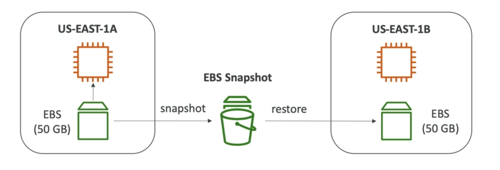

In [4]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/EBS-snapshot.jpeg')
new_image = img.resize((500, 170))
display(new_image)

#### EBS Snapshot Features:
EBS Snapshot archive:
- 75% cheaper (archive tier)
- 24 to 72 hrs for restoring archive

Recycle bin for EBS Snapshots:
- 1 to 365 days retention (setup rules), sometimes for accidental deletion

Fast Snapshot Restore: (while initializing snapshot which is big in size)
- expensive
- no latency on first use (force full initialization)

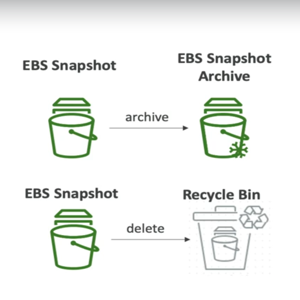

In [5]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/Snapshot-feature.jpeg')
new_image = img.resize((300, 300))
display(new_image)

#### How to create a EBS snapshot:
- Select the EBS Volume and click Actions
    - Create Snapshot
        - Description
        - Create

#### To check the snapshot created:
- Go to Snapshot option on the left hand side
    - Snapshot shown in the screen
        - snapshot id
        - volume id
        - owner id

#### To copy the snapshot created:
- Right click the EBS volume created
    - Select Copy Snapshot
        - Select Destination Region (can be created in any Region and AZs)
        - Copy Snapshot


#### To create Volume from a snapshot:
- From the snapshot page, select the snapshot 
- Go to Actions -> Create volume from snapshot
    - Volume type
    - size
    - AZ
    - Create Volume

#### Recycle bin in Snapshot:
- Recycle bin option is available from snapshot page in EBS
    - Create retention role
        - name
        - description
        - resource type
        - retention period
        - rule lock settings
        - Create

- The deleted EBS snapshot is found in the Resource option inside the Recycle bin page

#### To recover the deleted EBS snapshot:
- Go to Recycle bin page
    - Resource option (left side)
        - select the deleted snapshot 
            - Recover

#### Archive Snapshot:
- Select the snapshot from snapshot page
    - Actions
        - Archive snapshot

#### EBS Vs EC2 Instance store:

EBS:
- EBS is network drive, its is good but limited performance
- long term use.

EC2 Instance store:
- For high performance hardware disk
- Better IO performance
- Deleting EC2 instance will cause it to lose information stored in it (ephemeral)
- used for cache, temporary data, buffer, etc
- Backup and replication need to be performed regularly

#### EBS Volume Types:
- gp2/gp3 -> general purpose SSD
- io1/io2 -> provisioned IOPS High-performance SSD
- st l -> low cost HDD volume (frequently accessed, throughput intensive workloads)
- sc l -> lowest cost HDD volume (less frequently accessed workloads)


#### EBS attributes:
- IOPS
- Throughput
- Size

Only io1/io2 or gp2/gp3 can be used as boot volume (root)

#### Multi attach EBS:
- The same EBS volume can be attached to 2 or more (upto 16) EC2 instances in the same AZ only possible via io1/io2 volume type family.
    - must use file system thats cluster aware (not XFS, EXT4, etc,.)


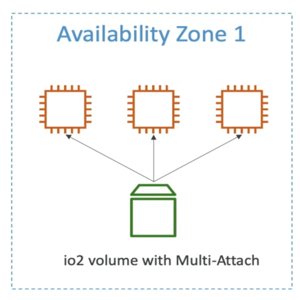

In [6]:
from PIL import Image 
from IPython.display import display

img = Image.open('images/multi-AZ-EBS.jpeg')
new_image = img.resize((300, 300))
display(new_image)